## Full Process of using LSTM Model

### 1 _ Pre processing

In [ ]:
# first we import the required librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# next we need to read our own dataset
df = pd.read_csv('/content/data.csv' , index_col = 'date' , parse_dates=True)
df.head()

,year,specefic_date,total sale_dollars,total state_bottle_cost,total state_bottle_retail,total bottles_sold,total volume_sold_liters
date,,,,,,,
2012-02-01,2012,02-01,5577.26,349.82,525.68,589,342.50
2012-03-01,2012,03-01,4756.82,277.15,416.99,561,321.38
2012-05-01,2012,05-01,7962.06,536.60,809.48,640,609.00
2012-08-01,2012,08-01,5981.40,395.47,595.39,656,427.50
2012-10-01,2012,10-01,9064.20,507.76,766.11,727,525.00


In [ ]:
# let's keep only the needed data for this process
df.drop(['year' , 'specefic_date' ,'total state_bottle_cost' , 'total state_bottle_retail' , 'total sale_dollars' , 'total volume_sold_liters'],axis = 1, inplace = True)
df.head()

,total bottles_sold
date,
2012-02-01,589
2012-03-01,561
2012-05-01,640
2012-08-01,656
2012-10-01,727


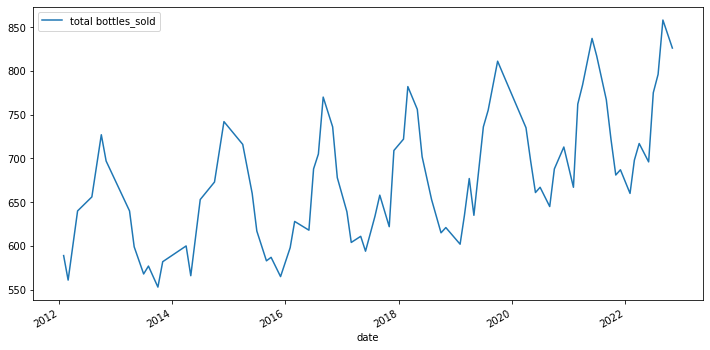

In [ ]:
# let's show the form of our data
df.plot(figsize = (12,6))

### 2 _ Dataset Integration

In [ ]:
# let's start by showing the len of the dataset
len(df)

78

In [ ]:
# We gonna take all the data for train ,excep the last 12 month that we gonna predict
X_train = df[:66]
X_test = df[66:]

In [ ]:
# Next a really important part is to normalise our data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# now we use the scaler in both test and train
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

### 3 _ Creating our Time Series

In [ ]:
# to generate out timeseries , we going to use the following Keras function
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# let's now define our generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(
                  scaled_train , 
                  scaled_train ,
                  length = n_input,
                  batch_size = n_features
            )

In [ ]:
# let's find out the size of the generator and train data
print(len(generator) , len(scaled_train))

63 66


In [ ]:
# let's now understand the principe of generator 
X , Y = generator[1]
print(f'Using This Array : {X} ')
print(f'We Gonna using this as target : {Y}')

Using This Array : [[[0.02816901]
  [0.30633803]
  [0.36267606]]] 
We Gonna using this as target : [[0.61267606]]


In [ ]:
# but we need to predict a whole month which is 12 month
n_input = 12
generator = TimeseriesGenerator(
                  scaled_train , 
                  scaled_train ,
                  length = n_input,
                  batch_size = n_features
            )

### 4 _ Creating Our Model

In [ ]:
# We all know that to create an LSTM model you are in need of keras library
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# now we pass into define our models setting considering Layers , Hidden , Input/Output and more
model = Sequential()
model.add(
    LSTM(
        100 , 
        activation = 'relu',
        input_shape = (n_input , n_features)
    )
)
model.add(
    Dense(1)
)
model.compile(
    optimizer = 'adam',
    loss = 'mse',
)

In [ ]:
# Its better to present a summary of our own model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Now the easiet Part , fit of our model
model.fit(
    generator , 
    epochs=50
  )

Epoch 1/50
54/54 [==============================] - 2s 6ms/step - loss: 0.0800
Epoch 2/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0465
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0399
Epoch 4/50
54/54 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 5/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 6/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0145
Epoch 7/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0420
Epoch 8/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0937
Epoch 9/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0368
Epoch 10/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0254
Epoch 11/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 12/50
54/54 [==============================] - 0s 6ms/step - loss: 0.0147
Epoch 13/50
54/54 [==============================

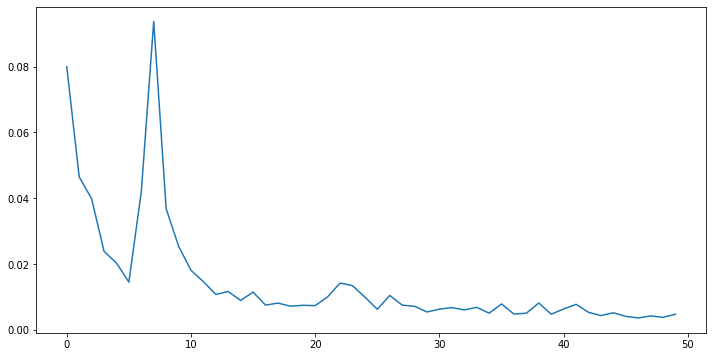

In [ ]:
# lets plot the cost function of our model
loss = model.history.history['loss']
plt.figure(figsize = (12 , 6))
plt.plot(
    range(len(loss)) , 
    loss
)

### 5 _ Evaluation Of Model

In [ ]:
# let's now try our model , we gonna give him the last 12 month of our train 
# and see if he gonna present a close result to the test
last_train_data = scaled_train[-12:]
last_train_data = last_train_data.reshape(
    (1 , n_input , n_features)
  )

In [ ]:
Last_train_predict = model.predict(last_train_data)
print(f"Prediction : {Last_train_predict[0]}")
print(f"Real Value : {scaled_test[0]}")

1/1 [==============================] - 0s 196ms/step
Prediction : [0.79489326]
Real Value : [0.75352113]


In [ ]:
# now let's test the whole data
test_prediction = []

first_data = scaled_train[-n_input:]
current_data = first_data.reshape((1 , n_input , n_features))

for i in range(len(scaled_test)):
  print(i)
  # make the predection
  current_pred = model.predict(current_data)[0]

  # append prection result
  test_prediction.append(current_pred)

  # use the next data and so on
  current_data = np.append(
      current_data[: , 1: , :],rediction Total Bottal
      [[current_pred]],
      axis = 1
  )

0
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 20ms/step
2
1/1 [==============================] - 0s 16ms/step
3
1/1 [==============================] - 0s 19ms/step
4
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 20ms/step
6
1/1 [==============================] - 0s 23ms/step
7
1/1 [==============================] - 0s 17ms/step
8
1/1 [==============================] - 0s 16ms/step
9
1/1 [==============================] - 0s 15ms/step
10
1/1 [==============================] - 0s 18ms/step
11
1/1 [==============================] - 0s 17ms/step


In [ ]:
# now we should inverse our scalled data
Y_pred = scaler.inverse_transform(test_prediction)
Y_test = scaler.inverse_transform(scaled_test)

In [ ]:
# let's now add the test and prediction in one dataset
X_test['Prediction Total Bottals'] = Y_pred
X_test.head()

<ipython-input-25-150dff171595>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Prediction Total Bottals'] = Y_pred


,total bottles_sold,Prediction Total Bottals
date,,
2021-09-01,767,778.749687
2021-10-01,722,734.568848
2021-11-01,681,703.767407
2021-12-01,687,697.626014
2022-02-01,660,694.662334


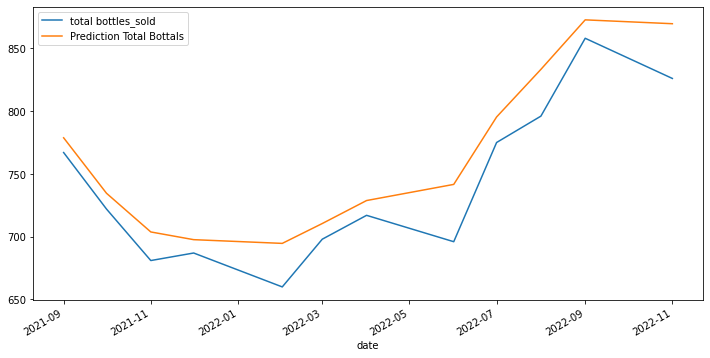

In [ ]:
# Let's plot our test with prediction data
X_test.plot(figsize = (12 , 6))